<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/main/C4/W3/ungraded_labs/C4_W3_Lab_2_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab: Using a multi-layer LSTM for forecasting

In this lab, you will use the same RNN architecure in the first lab but will instead stack [LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) layers instead of `SimpleRNN`.

## Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Utilities

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series

def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish
    
    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according 
                                  to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))
    
    return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """
    
    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern

def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level
    
    return noise

## Generate the Synthetic Data

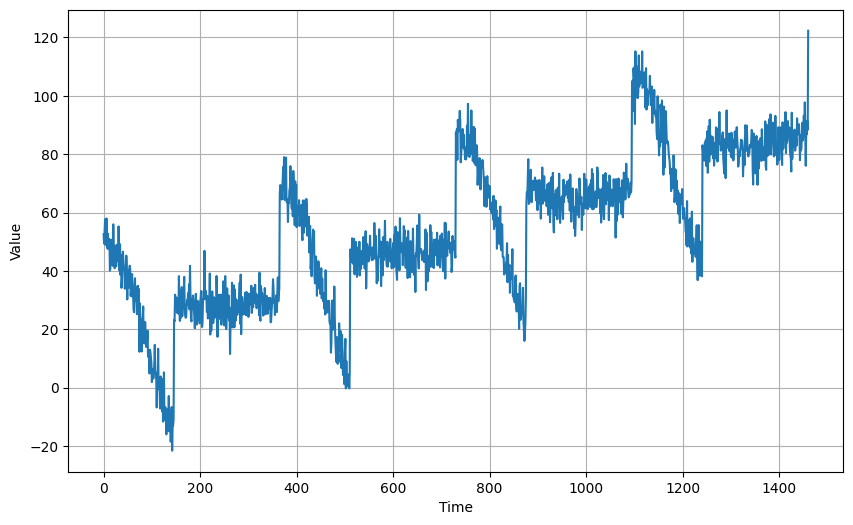

In [3]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

## Split the Dataset

In [4]:
# Define the split time
split_time = 1000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

## Prepare Features and Labels

In [5]:
# Parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [7]:
# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [38]:
for batch in dataset.take(1):  # Take one batch
    for element in batch:
        print(element.shape)

(32, 20)
(32,)


2024-07-09 15:33:44.227911: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Build the Model

As mentioned, you will swap `SimpleRNN` for `LSTM` in this lab. It is also set as bidirectional below but feel free to revise later and see what results you get. LSTMs are much more complex in their internal architecture than simpleRNNs. It implements a cell state that allows it to remember sequences better than simple implementations. This added complexity results in a bigger set of parameters to train and you'll see that when you print the model summary below.

In [8]:
# Build the Model
model_tune = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[window_size]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Print the model summary
model_tune.summary()

/Users/civye1/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ (None, 20, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 20, 64)         │         8,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,601 (131.25 KB)

 Trainable params: 33,601 (131.25 KB)

 Non-trainable params: 0 (0.00 B)

## Tune the Learning Rate

As usual, you will pick a learning rate by running the tuning code below.

In [9]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model_tune.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model_tune.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 18.6369 - learning_rate: 1.0000e-08
Epoch 2/100
21/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 18.1682

2024-07-09 14:46:50.434638: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/civye1/anaconda3/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 18.4102 - learning_rate: 1.1220e-08
Epoch 3/100
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 18.7309

2024-07-09 14:46:50.653186: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 18.7275 - learning_rate: 1.2589e-08
Epoch 4/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 18.7271

2024-07-09 14:46:50.861495: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 18.4653 - learning_rate: 1.4125e-08
Epoch 5/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 18.0894

2024-07-09 14:46:51.131302: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 18.1427 - learning_rate: 1.5849e-08
Epoch 6/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 18.0028

2024-07-09 14:46:51.399082: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 18.0540 - learning_rate: 1.7783e-08
Epoch 7/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 17.0435

2024-07-09 14:46:51.670226: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 17.2243 - learning_rate: 1.9953e-08
Epoch 8/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 16.2011

2024-07-09 14:46:51.937479: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 16.6684 - learning_rate: 2.2387e-08
Epoch 9/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 16.8711

2024-07-09 14:46:52.209009: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 16.8743 - learning_rate: 2.5119e-08
Epoch 10/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 16.4245

2024-07-09 14:46:52.476375: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 16.6255 - learning_rate: 2.8184e-08
Epoch 11/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 16.3955

2024-07-09 14:46:52.748135: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 16.3745 - learning_rate: 3.1623e-08
Epoch 12/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 15.3106

2024-07-09 14:46:53.019894: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 15.4583 - learning_rate: 3.5481e-08
Epoch 13/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 15.5945

2024-07-09 14:46:53.289914: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 15.7295 - learning_rate: 3.9811e-08
Epoch 14/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 14.9210

2024-07-09 14:46:53.566624: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 15.0935 - learning_rate: 4.4668e-08
Epoch 15/100
12/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 15.6872

2024-07-09 14:46:53.869394: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 15.2119 - learning_rate: 5.0119e-08
Epoch 16/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 14.8347

2024-07-09 14:46:54.187162: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 14.8307 - learning_rate: 5.6234e-08
Epoch 17/100
21/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 14.6469

2024-07-09 14:46:54.460163: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 14.6502 - learning_rate: 6.3096e-08
Epoch 18/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 14.4540

2024-07-09 14:46:54.737196: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 14.2861 - learning_rate: 7.0795e-08
Epoch 19/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 13.6672

2024-07-09 14:46:55.006497: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 13.7640 - learning_rate: 7.9433e-08
Epoch 20/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 13.0756

2024-07-09 14:46:55.274394: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 13.2296 - learning_rate: 8.9125e-08
Epoch 21/100
 5/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 15.7785 

2024-07-09 14:46:55.540714: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 14.0272 - learning_rate: 1.0000e-07
Epoch 22/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 15.3449

2024-07-09 14:46:55.904987: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 14.1401 - learning_rate: 1.1220e-07
Epoch 23/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 11.5554

2024-07-09 14:46:56.173308: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 12.0768 - learning_rate: 1.2589e-07
Epoch 24/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 11.9856

2024-07-09 14:46:56.443029: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 12.0523 - learning_rate: 1.4125e-07
Epoch 25/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 11.1312

2024-07-09 14:46:56.712304: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 11.3993 - learning_rate: 1.5849e-07
Epoch 26/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 11.1941

2024-07-09 14:46:56.981574: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 11.2283 - learning_rate: 1.7783e-07
Epoch 27/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 11.4314

2024-07-09 14:46:57.249202: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 11.2478 - learning_rate: 1.9953e-07
Epoch 28/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 10.4566

2024-07-09 14:46:57.517129: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 10.4620 - learning_rate: 2.2387e-07
Epoch 29/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 10.3992

2024-07-09 14:46:57.787078: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 10.0505 - learning_rate: 2.5119e-07
Epoch 30/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.8281

2024-07-09 14:46:58.058014: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.9194 - learning_rate: 2.8184e-07
Epoch 31/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.8657

2024-07-09 14:46:58.323866: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.7781 - learning_rate: 3.1623e-07
Epoch 32/100
12/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.2555

2024-07-09 14:46:58.604098: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.1750 - learning_rate: 3.5481e-07
Epoch 33/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.8755

2024-07-09 14:46:58.912516: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.9293 - learning_rate: 3.9811e-07
Epoch 34/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.8921

2024-07-09 14:46:59.180886: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.7953 - learning_rate: 4.4668e-07
Epoch 35/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.7103

2024-07-09 14:46:59.452145: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.6506 - learning_rate: 5.0119e-07
Epoch 36/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.2276

2024-07-09 14:46:59.720088: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.2407 - learning_rate: 5.6234e-07
Epoch 37/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.7782

2024-07-09 14:46:59.988368: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.0095 - learning_rate: 6.3096e-07
Epoch 38/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.0749

2024-07-09 14:47:00.258251: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.0756 - learning_rate: 7.0795e-07
Epoch 39/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.1863

2024-07-09 14:47:00.525160: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.0429 - learning_rate: 7.9433e-07
Epoch 40/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.7112

2024-07-09 14:47:00.793980: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.7865 - learning_rate: 8.9125e-07
Epoch 41/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.5628

2024-07-09 14:47:01.067399: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.6673 - learning_rate: 1.0000e-06
Epoch 42/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.1811

2024-07-09 14:47:01.341028: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.0646 - learning_rate: 1.1220e-06
Epoch 43/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.8430

2024-07-09 14:47:01.608606: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.7930 - learning_rate: 1.2589e-06
Epoch 44/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.6454

2024-07-09 14:47:01.874304: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.5870 - learning_rate: 1.4125e-06
Epoch 45/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.9461

2024-07-09 14:47:02.141847: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.0452 - learning_rate: 1.5849e-06
Epoch 46/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.9941

2024-07-09 14:47:02.410606: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.7014 - learning_rate: 1.7783e-06
Epoch 47/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.1392

2024-07-09 14:47:02.678397: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.1586 - learning_rate: 1.9953e-06
Epoch 48/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.4770

2024-07-09 14:47:02.943160: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.3734 - learning_rate: 2.2387e-06
Epoch 49/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.7326

2024-07-09 14:47:03.209808: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.7925 - learning_rate: 2.5119e-06
Epoch 50/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.0694

2024-07-09 14:47:03.473715: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.0351 - learning_rate: 2.8184e-06
Epoch 51/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.6030

2024-07-09 14:47:03.775228: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.5870 - learning_rate: 3.1623e-06
Epoch 52/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.7001

2024-07-09 14:47:04.045306: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.6765 - learning_rate: 3.5481e-06
Epoch 53/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.3454

2024-07-09 14:47:04.312889: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.3291 - learning_rate: 3.9811e-06
Epoch 54/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.2909

2024-07-09 14:47:04.578793: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.3073 - learning_rate: 4.4668e-06
Epoch 55/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.4524

2024-07-09 14:47:04.845873: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.3897 - learning_rate: 5.0119e-06
Epoch 56/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.0070

2024-07-09 14:47:05.112193: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.0322 - learning_rate: 5.6234e-06
Epoch 57/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.1059

2024-07-09 14:47:05.379699: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.0727 - learning_rate: 6.3096e-06
Epoch 58/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.5942

2024-07-09 14:47:05.647723: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.7033 - learning_rate: 7.0795e-06
Epoch 59/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.9212

2024-07-09 14:47:05.917826: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.9633 - learning_rate: 7.9433e-06
Epoch 60/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.1567

2024-07-09 14:47:06.184457: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.1393 - learning_rate: 8.9125e-06
Epoch 61/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.0286

2024-07-09 14:47:06.450883: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.9610 - learning_rate: 1.0000e-05
Epoch 62/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.8826

2024-07-09 14:47:06.717301: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.8387 - learning_rate: 1.1220e-05
Epoch 63/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.4535

2024-07-09 14:47:06.981705: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.5385 - learning_rate: 1.2589e-05
Epoch 64/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.3764

2024-07-09 14:47:07.248442: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.3213 - learning_rate: 1.4125e-05
Epoch 65/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.6574

2024-07-09 14:47:07.515435: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.7063 - learning_rate: 1.5849e-05
Epoch 66/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.0918

2024-07-09 14:47:07.782837: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.1003 - learning_rate: 1.7783e-05
Epoch 67/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.8609

2024-07-09 14:47:08.052292: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.7377 - learning_rate: 1.9953e-05
Epoch 68/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.0710

2024-07-09 14:47:08.320297: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.1240 - learning_rate: 2.2387e-05
Epoch 69/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.7531

2024-07-09 14:47:08.586394: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.3492 - learning_rate: 2.5119e-05
Epoch 70/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.5451

2024-07-09 14:47:08.883465: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.5643 - learning_rate: 2.8184e-05
Epoch 71/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.7785

2024-07-09 14:47:09.152472: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.8995 - learning_rate: 3.1623e-05
Epoch 72/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.2459

2024-07-09 14:47:09.419726: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.0767 - learning_rate: 3.5481e-05
Epoch 73/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.8235

2024-07-09 14:47:09.685800: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.9338 - learning_rate: 3.9811e-05
Epoch 74/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.6795

2024-07-09 14:47:09.950755: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.8249 - learning_rate: 4.4668e-05
Epoch 75/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.9432

2024-07-09 14:47:10.217569: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.9328 - learning_rate: 5.0119e-05
Epoch 76/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.1479

2024-07-09 14:47:10.483544: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.3375 - learning_rate: 5.6234e-05
Epoch 77/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.4356

2024-07-09 14:47:10.750418: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.5600 - learning_rate: 6.3096e-05
Epoch 78/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.4506

2024-07-09 14:47:11.017100: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.1466 - learning_rate: 7.0795e-05
Epoch 79/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.5669

2024-07-09 14:47:11.435988: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.1631 - learning_rate: 7.9433e-05
Epoch 80/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.4915

2024-07-09 14:47:11.707466: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.1081 - learning_rate: 8.9125e-05
Epoch 81/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.7348

2024-07-09 14:47:11.974770: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.8885 - learning_rate: 1.0000e-04
Epoch 82/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.4719

2024-07-09 14:47:12.241397: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.2489 - learning_rate: 1.1220e-04
Epoch 83/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.3469

2024-07-09 14:47:12.508672: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.7752 - learning_rate: 1.2589e-04
Epoch 84/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.2561

2024-07-09 14:47:12.774095: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.3564 - learning_rate: 1.4125e-04
Epoch 85/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.5549

2024-07-09 14:47:13.041465: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.5282 - learning_rate: 1.5849e-04
Epoch 86/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.1329

2024-07-09 14:47:13.309577: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.0376 - learning_rate: 1.7783e-04
Epoch 87/100
12/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.6240

2024-07-09 14:47:13.576913: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.3091 - learning_rate: 1.9953e-04
Epoch 88/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.1343

2024-07-09 14:47:13.884864: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.7009 - learning_rate: 2.2387e-04
Epoch 89/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.1521

2024-07-09 14:47:14.153574: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.4236 - learning_rate: 2.5119e-04
Epoch 90/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.5377

2024-07-09 14:47:14.420287: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.8417 - learning_rate: 2.8184e-04
Epoch 91/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.4826

2024-07-09 14:47:14.687934: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.4058 - learning_rate: 3.1623e-04
Epoch 92/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.8563

2024-07-09 14:47:14.956939: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.9472 - learning_rate: 3.5481e-04
Epoch 93/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.8647

2024-07-09 14:47:15.225373: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.0905 - learning_rate: 3.9811e-04
Epoch 94/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.6824

2024-07-09 14:47:15.494243: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.2020 - learning_rate: 4.4668e-04
Epoch 95/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 11.7413

2024-07-09 14:47:15.771203: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 11.6060 - learning_rate: 5.0119e-04
Epoch 96/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 11.6011

2024-07-09 14:47:16.041692: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 10.2911 - learning_rate: 5.6234e-04
Epoch 97/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 13.1892

2024-07-09 14:47:16.311511: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 12.7900 - learning_rate: 6.3096e-04
Epoch 98/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 16.4726

2024-07-09 14:47:16.581771: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 14.4650 - learning_rate: 7.0795e-04
Epoch 99/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.5301

2024-07-09 14:47:16.856516: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.8570 - learning_rate: 7.9433e-04
Epoch 100/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.8627

2024-07-09 14:47:17.124183: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 11.2439 - learning_rate: 8.9125e-04


2024-07-09 14:47:17.392094: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


(1e-07, 0.0001, 0.0, 20.0)

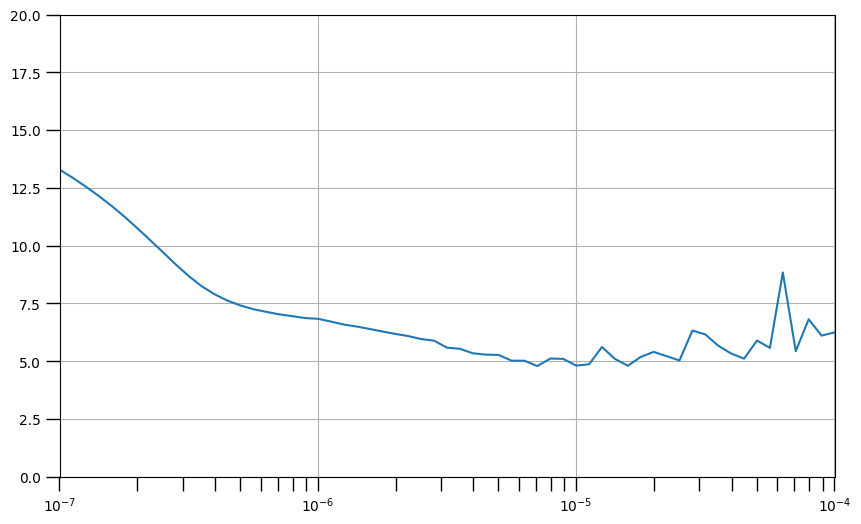

In [14]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
##plt.axis([1e-8, 1e-3, 0, 30])
plt.axis([1e-7, 1e-4, 0, 20])

## Train the Model

You can then proceed to train the model with your chosen learning rate. 

*Tip: When experimenting and you find yourself running different iterations of a model, you may want to use the [`clear_session()`](https://www.tensorflow.org/api_docs/python/tf/keras/backend/clear_session) method to declutter memory used by Keras. This is added in the first line below.*


In [15]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Set the learning rate
learning_rate = 6e-6

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(dataset,epochs=100)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 18.3100 - mae: 18.8055
Epoch 2/100
30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.7953 - mae: 7.2765

2024-07-09 14:54:24.603801: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.7677 - mae: 7.2489
Epoch 3/100
19/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.1461 - mae: 6.6232

2024-07-09 14:54:24.810292: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.0057 - mae: 6.4825
Epoch 4/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.6640 - mae: 6.1410

2024-07-09 14:54:25.030957: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.7554 - mae: 6.2345
Epoch 5/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.7928 - mae: 6.2740

2024-07-09 14:54:25.308121: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.8090 - mae: 6.2897
Epoch 6/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.4770 - mae: 5.9605

2024-07-09 14:54:25.579354: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.5127 - mae: 5.9958
Epoch 7/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.0791 - mae: 6.5470

2024-07-09 14:54:25.850530: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.1033 - mae: 6.5777
Epoch 8/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.9078 - mae: 5.3809

2024-07-09 14:54:26.122195: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.0561 - mae: 5.5318
Epoch 9/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.3279 - mae: 5.8105

2024-07-09 14:54:26.398849: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.3228 - mae: 5.8047
Epoch 10/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.8529 - mae: 5.3269

2024-07-09 14:54:26.716516: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.8910 - mae: 5.3673
Epoch 11/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5979 - mae: 5.0764

2024-07-09 14:54:27.046506: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.8186 - mae: 5.2979
Epoch 12/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.4142 - mae: 5.8984

2024-07-09 14:54:27.382416: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.2403 - mae: 5.7234
Epoch 13/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.7549 - mae: 5.2245

2024-07-09 14:54:27.657740: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.7871 - mae: 5.2584
Epoch 14/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.0310 - mae: 5.5167

2024-07-09 14:54:27.928118: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.9531 - mae: 5.4366
Epoch 15/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.9346 - mae: 5.4055

2024-07-09 14:54:28.196154: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.9521 - mae: 5.4237
Epoch 16/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.8709 - mae: 5.3514

2024-07-09 14:54:28.467988: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.8772 - mae: 5.3571
Epoch 17/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.8701 - mae: 5.3486 

2024-07-09 14:54:28.735995: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.7976 - mae: 5.2735
Epoch 18/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.7348 - mae: 5.2083

2024-07-09 14:54:29.032653: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.6716 - mae: 5.1460
Epoch 19/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5309 - mae: 5.0077

2024-07-09 14:54:29.306352: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5333 - mae: 5.0083
Epoch 20/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.6073 - mae: 5.0865

2024-07-09 14:54:29.579487: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.6669 - mae: 5.1457
Epoch 21/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4168 - mae: 4.8827

2024-07-09 14:54:29.847618: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5290 - mae: 5.0006
Epoch 22/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.1373 - mae: 4.6161

2024-07-09 14:54:30.116446: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.2498 - mae: 4.7282
Epoch 23/100
11/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.7802 - mae: 5.2575

2024-07-09 14:54:30.444761: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6434 - mae: 5.1187
Epoch 24/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4876 - mae: 4.9584

2024-07-09 14:54:30.758495: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5889 - mae: 5.0617
Epoch 25/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4963 - mae: 4.9777

2024-07-09 14:54:31.029149: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5070 - mae: 4.9837
Epoch 26/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.6818 - mae: 5.1568

2024-07-09 14:54:31.310949: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.7391 - mae: 5.2168
Epoch 27/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.6920 - mae: 5.1688

2024-07-09 14:54:31.588706: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.6356 - mae: 5.1114
Epoch 28/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4273 - mae: 4.9086

2024-07-09 14:54:31.857741: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4577 - mae: 4.9385
Epoch 29/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.7310 - mae: 5.2049

2024-07-09 14:54:32.125466: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.6203 - mae: 5.0940
Epoch 30/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4215 - mae: 4.9017

2024-07-09 14:54:32.395145: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4989 - mae: 4.9770
Epoch 31/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.3071 - mae: 4.7905

2024-07-09 14:54:32.667171: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.3705 - mae: 4.8520
Epoch 32/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.8485 - mae: 5.3309

2024-07-09 14:54:32.948042: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.6660 - mae: 5.1436
Epoch 33/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5656 - mae: 5.0466

2024-07-09 14:54:33.217429: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.7846 - mae: 5.2663
Epoch 34/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5973 - mae: 5.0796

2024-07-09 14:54:33.485141: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5807 - mae: 5.0609
Epoch 35/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.7526 - mae: 5.2269

2024-07-09 14:54:33.758237: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.9007 - mae: 5.3777
Epoch 36/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5343 - mae: 5.0092

2024-07-09 14:54:34.042631: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5191 - mae: 4.9933
Epoch 37/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4021 - mae: 4.8823

2024-07-09 14:54:34.312417: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4442 - mae: 4.9241
Epoch 38/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.2517 - mae: 4.7328

2024-07-09 14:54:34.580180: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.3824 - mae: 4.8621
Epoch 39/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.1892 - mae: 4.6660

2024-07-09 14:54:34.849894: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.3641 - mae: 4.8419
Epoch 40/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.6624 - mae: 5.1346

2024-07-09 14:54:35.120486: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5995 - mae: 5.0705
Epoch 41/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.6876 - mae: 5.1602

2024-07-09 14:54:35.389832: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.6726 - mae: 5.1460
Epoch 42/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.8464 - mae: 5.3339

2024-07-09 14:54:35.663911: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.6867 - mae: 5.1702
Epoch 43/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.2479 - mae: 4.7235

2024-07-09 14:54:35.938644: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.3181 - mae: 4.7941
Epoch 44/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5554 - mae: 5.0314

2024-07-09 14:54:36.206101: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5691 - mae: 5.0458
Epoch 45/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5329 - mae: 5.0066

2024-07-09 14:54:36.474549: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5412 - mae: 5.0139
Epoch 46/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5887 - mae: 5.0702

2024-07-09 14:54:36.759181: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5814 - mae: 5.0618
Epoch 47/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4130 - mae: 4.8828

2024-07-09 14:54:37.030780: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4380 - mae: 4.9086
Epoch 48/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.1782 - mae: 5.6515

2024-07-09 14:54:37.298457: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.9595 - mae: 5.4340
Epoch 49/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.9618 - mae: 5.4445

2024-07-09 14:54:37.567256: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.8376 - mae: 5.3172
Epoch 50/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.8828 - mae: 5.3575

2024-07-09 14:54:37.846167: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.6521 - mae: 5.1267
Epoch 51/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5154 - mae: 4.9846

2024-07-09 14:54:38.116528: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4572 - mae: 4.9289
Epoch 52/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5537 - mae: 5.0273

2024-07-09 14:54:38.386895: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5529 - mae: 5.0264
Epoch 53/100
13/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.5988 - mae: 5.0790

2024-07-09 14:54:38.654980: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.5106 - mae: 4.9891
Epoch 54/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5338 - mae: 5.0017

2024-07-09 14:54:38.957972: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5033 - mae: 4.9756
Epoch 55/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.6865 - mae: 5.1524

2024-07-09 14:54:39.231703: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5960 - mae: 5.0657
Epoch 56/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5087 - mae: 4.9916

2024-07-09 14:54:39.508955: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5169 - mae: 4.9987
Epoch 57/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.7205 - mae: 5.1934

2024-07-09 14:54:39.777288: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5552 - mae: 5.0287
Epoch 58/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.7592 - mae: 5.2300

2024-07-09 14:54:40.046767: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.7276 - mae: 5.1998
Epoch 59/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4374 - mae: 4.9155

2024-07-09 14:54:40.314174: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4268 - mae: 4.9045
Epoch 60/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.3324 - mae: 4.8110

2024-07-09 14:54:40.582411: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.3182 - mae: 4.7959
Epoch 61/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5648 - mae: 5.0495

2024-07-09 14:54:40.850297: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.6116 - mae: 5.0944
Epoch 62/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.3249 - mae: 4.7996

2024-07-09 14:54:41.119447: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.3892 - mae: 4.8633
Epoch 63/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5242 - mae: 4.9987

2024-07-09 14:54:41.388295: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5153 - mae: 4.9908
Epoch 64/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.2509 - mae: 4.7255

2024-07-09 14:54:41.662625: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.3996 - mae: 4.8751
Epoch 65/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4987 - mae: 4.9638

2024-07-09 14:54:41.932597: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.3900 - mae: 4.8578
Epoch 66/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4314 - mae: 4.9027

2024-07-09 14:54:42.201703: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4277 - mae: 4.8998
Epoch 67/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.7541 - mae: 5.2334

2024-07-09 14:54:42.470343: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.6363 - mae: 5.1141
Epoch 68/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5293 - mae: 5.0100

2024-07-09 14:54:42.738848: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4950 - mae: 4.9747
Epoch 69/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.6170 - mae: 5.0994

2024-07-09 14:54:43.007951: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5885 - mae: 5.0700
Epoch 70/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5504 - mae: 5.0312

2024-07-09 14:54:43.276593: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5287 - mae: 5.0081
Epoch 71/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.3932 - mae: 4.8642

2024-07-09 14:54:43.545487: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4488 - mae: 4.9208
Epoch 72/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5594 - mae: 5.0364

2024-07-09 14:54:43.831664: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5469 - mae: 5.0245
Epoch 73/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.1446 - mae: 4.6226

2024-07-09 14:54:44.102291: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.2948 - mae: 4.7720
Epoch 74/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4792 - mae: 4.9604

2024-07-09 14:54:44.373688: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4973 - mae: 4.9778
Epoch 75/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.0858 - mae: 4.5550

2024-07-09 14:54:44.641504: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.3292 - mae: 4.8013
Epoch 76/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.3615 - mae: 4.8290

2024-07-09 14:54:44.912290: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.3461 - mae: 4.8178
Epoch 77/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.3034 - mae: 4.7852

2024-07-09 14:54:45.182951: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4027 - mae: 4.8824
Epoch 78/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.2620 - mae: 4.7315

2024-07-09 14:54:45.453904: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.3136 - mae: 4.7837
Epoch 79/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5007 - mae: 4.9743

2024-07-09 14:54:45.722633: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4708 - mae: 4.9459
Epoch 80/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.9602 - mae: 4.4314

2024-07-09 14:54:45.991483: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.1146 - mae: 4.5876
Epoch 81/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.3023 - mae: 4.7759

2024-07-09 14:54:46.260188: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.3419 - mae: 4.8171
Epoch 82/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.8735 - mae: 5.3495

2024-07-09 14:54:46.530293: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.7739 - mae: 5.2499
Epoch 83/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.3710 - mae: 4.8418

2024-07-09 14:54:46.809004: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.3572 - mae: 4.8295
Epoch 84/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4399 - mae: 4.9147

2024-07-09 14:54:47.077628: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.3759 - mae: 4.8506
Epoch 85/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.1531 - mae: 4.6244

2024-07-09 14:54:47.346608: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.3670 - mae: 4.8412
Epoch 86/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5222 - mae: 5.0045

2024-07-09 14:54:47.616633: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4758 - mae: 4.9547
Epoch 87/100
19/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5444 - mae: 5.0216

2024-07-09 14:54:47.896962: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4764 - mae: 4.9526
Epoch 88/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.1196 - mae: 4.5929

2024-07-09 14:54:48.188555: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.2322 - mae: 4.7060
Epoch 89/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4988 - mae: 4.9734

2024-07-09 14:54:48.457857: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.3800 - mae: 4.8544
Epoch 90/100
12/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.3391 - mae: 4.8092

2024-07-09 14:54:48.728685: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.3856 - mae: 4.8572
Epoch 91/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.7304 - mae: 5.2126

2024-07-09 14:54:49.028493: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.7606 - mae: 5.2417
Epoch 92/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.8077 - mae: 5.2901

2024-07-09 14:54:49.299103: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.7263 - mae: 5.2061
Epoch 93/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5139 - mae: 4.9853

2024-07-09 14:54:49.569002: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5796 - mae: 5.0536
Epoch 94/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.3166 - mae: 4.7889

2024-07-09 14:54:49.839197: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.3243 - mae: 4.7978
Epoch 95/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5841 - mae: 5.0661

2024-07-09 14:54:50.109159: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5058 - mae: 4.9832
Epoch 96/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4016 - mae: 4.8677

2024-07-09 14:54:50.379618: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.3868 - mae: 4.8547
Epoch 97/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5161 - mae: 5.0005

2024-07-09 14:54:50.649042: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4713 - mae: 4.9530
Epoch 98/100
22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.2787 - mae: 4.7579

2024-07-09 14:54:50.919362: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.3650 - mae: 4.8442
Epoch 99/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.3384 - mae: 4.8197

2024-07-09 14:54:51.188776: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.3746 - mae: 4.8527
Epoch 100/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.7635 - mae: 5.2418

2024-07-09 14:54:51.458549: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5718 - mae: 5.0503


2024-07-09 14:54:51.728617: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


## Model Prediction

You will then generate batches of windows to generate predictions that align with the validation set.

In [31]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
        
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


2024-07-09 15:18:08.636220: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


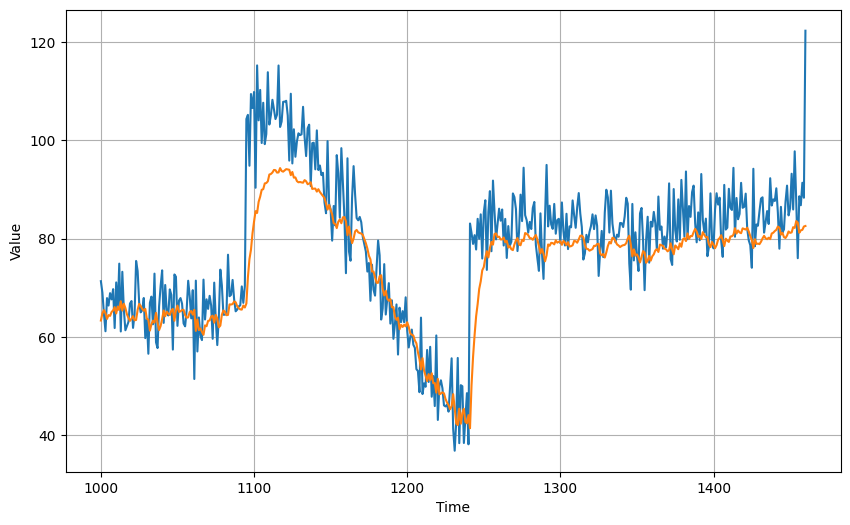

In [32]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

You can then generate the metrics to evaluate the model's performance.

In [33]:
# Compute the MSE and MAE
print(tf.keras.metrics.mse(x_valid, results).numpy())
print(tf.keras.metrics.mae(x_valid, results).numpy())

72.532265
6.1858096


## Wrap Up

This concludes this short exercise on using LSTMs for time series forecasting. Next week, you will build upon this and add convolutions. Then, you will start to move away from synthetic data and use real-world datasets. See you there!

## Optional: Including a Validation Set while Training

Back in the first course of this specialization, you saw how you can also monitor the performance of your model against a validation set while training. You can also do that for this lab. 

First, you need to generate a `val_set` which are data windows and labels that your model can accept. You can simply reuse the `windowed_dataset` function for that and you can pass in the `x_valid` points to generate the windows.

In [34]:
# Generate data windows of the validation set
val_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

You can then do the same training as before but pass in the `val_set` to the `validation_data` parameter of the `fit()` method.

In [35]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Set the learning rate
learning_rate = 2e-6

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(dataset,epochs=100, validation_data=val_set)

Epoch 1/100
     31/Unknown 1s 5ms/step - loss: 63.8428 - mae: 64.3408

2024-07-09 15:22:26.990875: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 63.0381 - mae: 63.5360 - val_loss: 21.8166 - val_mae: 22.3118
Epoch 2/100
20/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 11.4611 - mae: 11.9484

2024-07-09 15:22:27.266560: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 10.9604 - mae: 11.4463 - val_loss: 21.1549 - val_mae: 21.6514
Epoch 3/100
20/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.4872 - mae: 8.9696

2024-07-09 15:22:27.485222: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:27.530878: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8.3767 - mae: 8.8594 - val_loss: 17.4693 - val_mae: 17.9648
Epoch 4/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.6987 - mae: 8.1812

2024-07-09 15:22:27.745082: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:27.790364: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.5473 - mae: 8.0294 - val_loss: 14.0719 - val_mae: 14.5655
Epoch 5/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.2906 - mae: 8.7757  

2024-07-09 15:22:28.065001: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:28.109687: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.7359 - mae: 8.2194 - val_loss: 13.1183 - val_mae: 13.6133
Epoch 6/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.2610 - mae: 7.7458

2024-07-09 15:22:28.381941: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:28.427603: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.0687 - mae: 7.5509 - val_loss: 11.4993 - val_mae: 11.9927
Epoch 7/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.3042 - mae: 7.7885

2024-07-09 15:22:28.701572: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:28.747034: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.9803 - mae: 7.4613 - val_loss: 10.3638 - val_mae: 10.8560
Epoch 8/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.4205 - mae: 6.8998

2024-07-09 15:22:29.021973: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:29.068542: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.5200 - mae: 6.9995 - val_loss: 9.9430 - val_mae: 10.4319
Epoch 9/100
 8/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.2190 - mae: 5.6955 

2024-07-09 15:22:29.343020: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:29.390702: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.9718 - mae: 6.4502 - val_loss: 9.9417 - val_mae: 10.4319
Epoch 10/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.9163 - mae: 6.3895

2024-07-09 15:22:29.667027: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:29.714510: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.0753 - mae: 6.5507 - val_loss: 8.5322 - val_mae: 9.0185
Epoch 11/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.7261 - mae: 6.2064

2024-07-09 15:22:29.988180: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:30.036386: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.8795 - mae: 6.3608 - val_loss: 8.3233 - val_mae: 8.8109
Epoch 12/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.5934 - mae: 7.0723

2024-07-09 15:22:30.309700: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:30.357546: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.3215 - mae: 6.8018 - val_loss: 7.8840 - val_mae: 8.3732
Epoch 13/100
 7/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.9581 - mae: 6.4269

2024-07-09 15:22:30.632210: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:30.680115: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.6697 - mae: 6.1446 - val_loss: 7.4639 - val_mae: 7.9435
Epoch 14/100
 8/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.9025 - mae: 6.3769 

2024-07-09 15:22:30.985447: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:31.034295: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.8742 - mae: 6.3500 - val_loss: 8.0003 - val_mae: 8.4849
Epoch 15/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.4324 - mae: 5.9116

2024-07-09 15:22:31.308351: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:31.356208: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.6176 - mae: 6.0955 - val_loss: 7.3977 - val_mae: 7.8775
Epoch 16/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.4409 - mae: 5.9155

2024-07-09 15:22:31.628104: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:31.675891: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.5310 - mae: 6.0068 - val_loss: 8.3752 - val_mae: 8.8631
Epoch 17/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.6697 - mae: 6.1535

2024-07-09 15:22:31.948431: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:31.996659: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.6750 - mae: 6.1568 - val_loss: 7.8340 - val_mae: 8.3189
Epoch 18/100
 3/31 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 6.7105 - mae: 7.1945

2024-07-09 15:22:32.269322: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:32.317252: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.7791 - mae: 6.2574 - val_loss: 7.9731 - val_mae: 8.4599
Epoch 19/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.3353 - mae: 5.8145

2024-07-09 15:22:32.644569: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:32.692968: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.3855 - mae: 5.8650 - val_loss: 7.2867 - val_mae: 7.7721
Epoch 20/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.7697 - mae: 6.2398

2024-07-09 15:22:32.967562: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:33.015881: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.5931 - mae: 6.0654 - val_loss: 7.6263 - val_mae: 8.1105
Epoch 21/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.7724 - mae: 6.2458

2024-07-09 15:22:33.287567: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:33.335421: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.5685 - mae: 6.0425 - val_loss: 6.9553 - val_mae: 7.4383
Epoch 22/100
 8/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.0107 - mae: 5.4867 

2024-07-09 15:22:33.610943: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:33.660407: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.3237 - mae: 5.8018 - val_loss: 7.1978 - val_mae: 7.6838
Epoch 23/100
 8/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.2871 - mae: 5.7690 

2024-07-09 15:22:33.946371: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:33.994539: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.3713 - mae: 5.8519 - val_loss: 7.3668 - val_mae: 7.8482
Epoch 24/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.5639 - mae: 6.0480

2024-07-09 15:22:34.270044: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:34.318274: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.4068 - mae: 5.8880 - val_loss: 7.7288 - val_mae: 8.2146
Epoch 25/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.2973 - mae: 5.7839

2024-07-09 15:22:34.592079: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:34.640148: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.2460 - mae: 5.7296 - val_loss: 7.6585 - val_mae: 8.1446
Epoch 26/100
 8/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4339 - mae: 4.9037 

2024-07-09 15:22:34.912937: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:34.962318: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.9587 - mae: 5.4346 - val_loss: 7.8605 - val_mae: 8.3453
Epoch 27/100
 8/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.8012 - mae: 5.2667 

2024-07-09 15:22:35.241058: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:35.289030: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.0122 - mae: 5.4863 - val_loss: 7.0785 - val_mae: 7.5614
Epoch 28/100
 8/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5395 - mae: 5.0170 

2024-07-09 15:22:35.562888: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:35.611524: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.9072 - mae: 5.3854 - val_loss: 6.6030 - val_mae: 7.0874
Epoch 29/100
 8/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.8672 - mae: 6.3375 

2024-07-09 15:22:35.913944: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:35.963587: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.2179 - mae: 5.6905 - val_loss: 7.2420 - val_mae: 7.7239
Epoch 30/100
 8/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.8550 - mae: 5.3248 

2024-07-09 15:22:36.236880: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:36.285622: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.9381 - mae: 5.4153 - val_loss: 7.7985 - val_mae: 8.2840
Epoch 31/100
 8/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.1794 - mae: 5.6459 

2024-07-09 15:22:36.558942: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:36.606568: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.0304 - mae: 5.5034 - val_loss: 7.0816 - val_mae: 7.5642
Epoch 32/100
14/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.8375 - mae: 5.3178

2024-07-09 15:22:36.883557: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:36.931964: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.8667 - mae: 5.3438 - val_loss: 8.2276 - val_mae: 8.7159
Epoch 33/100
 8/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.1460 - mae: 5.6326 

2024-07-09 15:22:37.224200: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:37.278522: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.1233 - mae: 5.6038 - val_loss: 7.3536 - val_mae: 7.8350
Epoch 34/100
 8/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.7628 - mae: 5.2341 

2024-07-09 15:22:37.561499: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:37.610015: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.9188 - mae: 5.3940 - val_loss: 6.6044 - val_mae: 7.0896
Epoch 35/100
 8/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.3605 - mae: 4.8365 

2024-07-09 15:22:37.898818: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:37.949250: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.5552 - mae: 5.0310 - val_loss: 7.0358 - val_mae: 7.5184
Epoch 36/100
 8/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.2682 - mae: 4.7412 

2024-07-09 15:22:38.225550: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:38.275476: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6021 - mae: 5.0793 - val_loss: 7.6994 - val_mae: 8.1857
Epoch 37/100
 8/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.8603 - mae: 5.3405 

2024-07-09 15:22:38.548421: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:38.596354: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.8782 - mae: 5.3585 - val_loss: 6.5866 - val_mae: 7.0720
Epoch 38/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.9790 - mae: 5.4530

2024-07-09 15:22:38.871689: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:38.919743: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.9166 - mae: 5.3898 - val_loss: 6.8635 - val_mae: 7.3480
Epoch 39/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.8760 - mae: 5.3533

2024-07-09 15:22:39.192756: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:39.240603: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.8329 - mae: 5.3084 - val_loss: 7.1314 - val_mae: 7.6113
Epoch 40/100
 8/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.2222 - mae: 4.6896 

2024-07-09 15:22:39.515741: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:39.564393: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.5568 - mae: 5.0295 - val_loss: 6.9949 - val_mae: 7.4748
Epoch 41/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4366 - mae: 4.9138

2024-07-09 15:22:39.841035: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:39.888749: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.5821 - mae: 5.0595 - val_loss: 6.8799 - val_mae: 7.3617
Epoch 42/100
 8/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.9689 - mae: 5.4470 

2024-07-09 15:22:40.162116: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:40.210373: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.7889 - mae: 5.2659 - val_loss: 6.1704 - val_mae: 6.6539
Epoch 43/100
 8/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.1870 - mae: 4.6599 

2024-07-09 15:22:40.495655: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:40.586671: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.4797 - mae: 4.9545 - val_loss: 7.0377 - val_mae: 7.5158
Epoch 44/100
 8/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.2351 - mae: 4.7062 

2024-07-09 15:22:40.898022: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:40.948754: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.5625 - mae: 5.0378 - val_loss: 7.6362 - val_mae: 8.1250
Epoch 45/100
 8/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5661 - mae: 5.0336 

2024-07-09 15:22:41.246121: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:41.325227: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.6069 - mae: 5.0781 - val_loss: 6.2107 - val_mae: 6.6929
Epoch 46/100
 8/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.2509 - mae: 4.7308 

2024-07-09 15:22:41.608000: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:41.656059: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6232 - mae: 5.1004 - val_loss: 6.1713 - val_mae: 6.6477
Epoch 47/100
 8/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.9816 - mae: 4.4466 

2024-07-09 15:22:41.931287: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:41.979529: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.5249 - mae: 4.9972 - val_loss: 6.3578 - val_mae: 6.8434
Epoch 48/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.6077 - mae: 5.0866

2024-07-09 15:22:42.253786: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:42.302075: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.5665 - mae: 5.0422 - val_loss: 6.2350 - val_mae: 6.7158
Epoch 49/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.3575 - mae: 4.8339

2024-07-09 15:22:42.574967: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:42.622795: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.5323 - mae: 5.0088 - val_loss: 5.8039 - val_mae: 6.2809
Epoch 50/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.6501 - mae: 5.1226

2024-07-09 15:22:42.896438: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:42.944402: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6706 - mae: 5.1451 - val_loss: 6.8197 - val_mae: 7.2984
Epoch 51/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.1099 - mae: 5.5923

2024-07-09 15:22:43.218967: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:43.267118: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.0006 - mae: 5.4817 - val_loss: 7.7169 - val_mae: 8.2062
Epoch 52/100
 8/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.2308 - mae: 5.7163 

2024-07-09 15:22:43.541843: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:43.589668: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.7889 - mae: 5.2673 - val_loss: 7.1938 - val_mae: 7.6760
Epoch 53/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.2186 - mae: 5.6983

2024-07-09 15:22:43.865544: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:43.913204: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.9544 - mae: 5.4320 - val_loss: 7.7045 - val_mae: 8.1943
Epoch 54/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.7908 - mae: 5.2617

2024-07-09 15:22:44.186055: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:44.234113: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.8015 - mae: 5.2743 - val_loss: 6.2870 - val_mae: 6.7697
Epoch 55/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.7473 - mae: 5.2193

2024-07-09 15:22:44.507436: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:44.554911: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6962 - mae: 5.1704 - val_loss: 6.3507 - val_mae: 6.8350
Epoch 56/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4046 - mae: 4.8797

2024-07-09 15:22:44.827794: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:44.875542: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.5463 - mae: 5.0213 - val_loss: 6.0041 - val_mae: 6.4864
Epoch 57/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4548 - mae: 4.9294

2024-07-09 15:22:45.148128: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:45.196244: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6297 - mae: 5.1062 - val_loss: 6.9398 - val_mae: 7.4185
Epoch 58/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5148 - mae: 4.9899

2024-07-09 15:22:45.471058: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:45.519299: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.5835 - mae: 5.0591 - val_loss: 6.5545 - val_mae: 7.0346
Epoch 59/100


2024-07-09 15:22:45.812589: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:45.864547: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.5536 - mae: 5.0315 - val_loss: 6.6805 - val_mae: 7.1579
Epoch 60/100
 8/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.8109 - mae: 5.2877 

2024-07-09 15:22:46.276502: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:46.325332: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6682 - mae: 5.1414 - val_loss: 6.3715 - val_mae: 6.8527
Epoch 61/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.9686 - mae: 5.4449

2024-07-09 15:22:46.599896: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:46.647987: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.7591 - mae: 5.2338 - val_loss: 6.0256 - val_mae: 6.5055
Epoch 62/100
 8/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.2068 - mae: 4.6789 

2024-07-09 15:22:46.923926: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:46.971993: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.5253 - mae: 4.9999 - val_loss: 7.4482 - val_mae: 7.9373
Epoch 63/100
 8/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.8064 - mae: 5.2779 

2024-07-09 15:22:47.249029: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:47.297115: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.7503 - mae: 5.2215 - val_loss: 8.5076 - val_mae: 8.9967
Epoch 64/100
 8/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.6842 - mae: 5.1607 

2024-07-09 15:22:47.571775: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:47.619659: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.7936 - mae: 5.2709 - val_loss: 7.3353 - val_mae: 7.8202
Epoch 65/100
 8/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.1147 - mae: 4.6002 

2024-07-09 15:22:47.893901: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:47.941805: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.5967 - mae: 5.0776 - val_loss: 5.9357 - val_mae: 6.4183
Epoch 66/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.6358 - mae: 5.1138

2024-07-09 15:22:48.215479: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:48.262852: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.7849 - mae: 5.2631 - val_loss: 5.8103 - val_mae: 6.2948
Epoch 67/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.3690 - mae: 4.8411

2024-07-09 15:22:48.537088: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:48.584823: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.4966 - mae: 4.9701 - val_loss: 6.2843 - val_mae: 6.7689
Epoch 68/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.1931 - mae: 5.6705

2024-07-09 15:22:48.858755: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:48.906547: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.8966 - mae: 5.3743 - val_loss: 6.0277 - val_mae: 6.5074
Epoch 69/100
 8/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.2062 - mae: 4.6673 

2024-07-09 15:22:49.181206: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:49.229061: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.3820 - mae: 4.8517 - val_loss: 6.0549 - val_mae: 6.5377
Epoch 70/100
 8/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.9424 - mae: 5.4238 

2024-07-09 15:22:49.503514: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:49.551355: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.8707 - mae: 5.3493 - val_loss: 6.1326 - val_mae: 6.6169
Epoch 71/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4698 - mae: 4.9437

2024-07-09 15:22:49.826039: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:49.873731: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.4953 - mae: 4.9706 - val_loss: 7.6184 - val_mae: 8.1085
Epoch 72/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.3366 - mae: 5.8172

2024-07-09 15:22:50.147451: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:50.195348: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.9496 - mae: 5.4272 - val_loss: 6.7780 - val_mae: 7.2551
Epoch 73/100
 8/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5720 - mae: 5.0481 

2024-07-09 15:22:50.468075: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:50.516248: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.5191 - mae: 4.9979 - val_loss: 6.7071 - val_mae: 7.1852
Epoch 74/100
 8/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.0763 - mae: 4.5518 

2024-07-09 15:22:50.809093: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:50.859013: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.3641 - mae: 4.8392 - val_loss: 6.5968 - val_mae: 7.0734
Epoch 75/100
 8/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.2044 - mae: 5.6904 

2024-07-09 15:22:51.139718: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:51.191530: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.7899 - mae: 5.2683 - val_loss: 6.4953 - val_mae: 6.9717
Epoch 76/100
 8/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.0425 - mae: 4.5193 

2024-07-09 15:22:51.467835: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:51.515341: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.3929 - mae: 4.8691 - val_loss: 6.1798 - val_mae: 6.6623
Epoch 77/100
 8/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.6177 - mae: 5.0912 

2024-07-09 15:22:51.796820: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:51.846664: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.4968 - mae: 4.9707 - val_loss: 6.1585 - val_mae: 6.6403
Epoch 78/100
 8/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.2332 - mae: 4.7081 

2024-07-09 15:22:52.128576: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:52.176500: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.4198 - mae: 4.8934 - val_loss: 6.6932 - val_mae: 7.1726
Epoch 79/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4210 - mae: 4.8927

2024-07-09 15:22:52.451741: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:52.499425: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.4279 - mae: 4.8990 - val_loss: 5.8312 - val_mae: 6.3109
Epoch 80/100
 8/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.2636 - mae: 4.7448 

2024-07-09 15:22:52.775077: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:52.822914: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.3455 - mae: 4.8228 - val_loss: 7.2842 - val_mae: 7.7715
Epoch 81/100
 8/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4251 - mae: 4.9041 

2024-07-09 15:22:53.099028: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:53.147079: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.5235 - mae: 5.0021 - val_loss: 6.5898 - val_mae: 7.0676
Epoch 82/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.3410 - mae: 4.8151

2024-07-09 15:22:53.427563: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:53.475411: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.4534 - mae: 4.9294 - val_loss: 6.7974 - val_mae: 7.2778
Epoch 83/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.6629 - mae: 5.1403

2024-07-09 15:22:53.750896: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:53.798714: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6333 - mae: 5.1093 - val_loss: 6.0629 - val_mae: 6.5461
Epoch 84/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.6062 - mae: 5.0844

2024-07-09 15:22:54.074052: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:54.121242: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.5335 - mae: 5.0096 - val_loss: 7.5497 - val_mae: 8.0401
Epoch 85/100
 8/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5148 - mae: 4.9828 

2024-07-09 15:22:54.396006: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:54.444502: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.5326 - mae: 5.0089 - val_loss: 6.2591 - val_mae: 6.7389
Epoch 86/100
 7/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.4014 - mae: 4.8620 

2024-07-09 15:22:54.720209: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:54.768248: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.4990 - mae: 4.9692 - val_loss: 5.5003 - val_mae: 5.9826
Epoch 87/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.2530 - mae: 4.7250

2024-07-09 15:22:55.078094: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:55.126101: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.3749 - mae: 4.8486 - val_loss: 5.4950 - val_mae: 5.9761
Epoch 88/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4701 - mae: 4.9543

2024-07-09 15:22:55.400911: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:55.448864: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.5062 - mae: 4.9890 - val_loss: 6.0641 - val_mae: 6.5439
Epoch 89/100
 8/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.8572 - mae: 5.3335 

2024-07-09 15:22:55.724249: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:55.805791: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.6831 - mae: 5.1570 - val_loss: 5.3932 - val_mae: 5.8738
Epoch 90/100
 7/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.5290 - mae: 5.0006 

2024-07-09 15:22:56.093427: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:56.141902: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.6317 - mae: 5.1041 - val_loss: 5.7298 - val_mae: 6.2121
Epoch 91/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.6005 - mae: 5.0823

2024-07-09 15:22:56.428720: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:56.476979: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.5277 - mae: 5.0067 - val_loss: 5.7085 - val_mae: 6.1910
Epoch 92/100
 8/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5367 - mae: 5.0114 

2024-07-09 15:22:56.752506: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:56.800678: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.5100 - mae: 4.9825 - val_loss: 5.3514 - val_mae: 5.8307
Epoch 93/100
 8/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.9397 - mae: 5.4121 

2024-07-09 15:22:57.076381: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:57.124194: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.5996 - mae: 5.0715 - val_loss: 5.7153 - val_mae: 6.1965
Epoch 94/100
 8/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.7548 - mae: 4.2209 

2024-07-09 15:22:57.399665: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:57.447705: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.3214 - mae: 4.7944 - val_loss: 6.3861 - val_mae: 6.8667
Epoch 95/100
 8/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4062 - mae: 4.8901 

2024-07-09 15:22:57.724045: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:57.771729: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.4094 - mae: 4.8897 - val_loss: 5.8759 - val_mae: 6.3545
Epoch 96/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.2663 - mae: 4.7417

2024-07-09 15:22:58.048510: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:58.096051: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.3737 - mae: 4.8486 - val_loss: 5.3915 - val_mae: 5.8710
Epoch 97/100
 8/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5719 - mae: 5.0580 

2024-07-09 15:22:58.371366: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:58.419227: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6625 - mae: 5.1450 - val_loss: 5.3215 - val_mae: 5.7999
Epoch 98/100
15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.7414 - mae: 5.2145

2024-07-09 15:22:58.694675: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:58.742455: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6343 - mae: 5.1092 - val_loss: 5.3522 - val_mae: 5.8319
Epoch 99/100
 8/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.2049 - mae: 4.6789 

2024-07-09 15:22:59.018133: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:59.065693: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.4851 - mae: 4.9579 - val_loss: 6.6645 - val_mae: 7.1461
Epoch 100/100
 8/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.6442 - mae: 5.1156 

2024-07-09 15:22:59.342560: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:59.390305: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.5725 - mae: 5.0468 - val_loss: 5.6938 - val_mae: 6.1754


2024-07-09 15:22:59.665790: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-09 15:22:59.713156: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
